In [44]:
import zipfile
import numpy as np
from sklearn.cluster import DBSCAN
import geopandas as gpd
import os
import pandas as pd
from shapely.ops import unary_union
from shapely.ops import nearest_points
from shapely.geometry import Point
from shapely.geometry import MultiPoint, MultiPolygon, Polygon
from geopy.geocoders import Nominatim
import re
import time
import contextily as ctx
from sklearn.preprocessing import StandardScaler
from geopy.extra.rate_limiter import RateLimiter
from tqdm import tqdm
import matplotlib.pyplot as plt
from shapely.geometry import box

##load CSV
crimes_df = pd.read_csv(
    "C:\\Users\\Rbrig\\OneDrive\\Documents\\GIS Projects\\GIS 322\\Final Project\\data\\real_phx_crimes.csv",
    dtype={'INC NUMBER': str},
    low_memory=False
)


In [2]:
print(crimes_df.columns.tolist())


['Incident Number', 'Occurred From', 'Occurred To', 'Type', 'Address', 'ZIP', 'Location', 'Unnamed: 7', 'Unnamed: 8']


In [3]:
##data cleaning and prep, only needed if redoing latest 1000 crimes .csv

##load the dataset and drop empty columns
#df = pd.read_csv(r"C:\Users\Rbrig\OneDrive\Documents\GIS Projects\GIS 322\Final Project\data\real_phx_crimes.csv",
                 #dtype={'Incident Number': str},
                 #usecols=lambda col: col not in ['Unnamed: 7', 'Unnamed: 8'])

##convert 'Occurred From' to datetime
#df["Occurred From"] = pd.to_datetime(df["Occurred From"], errors="coerce")

##drop rows w/ missing or invalid dates
#df = df.dropna(subset=["Occurred From"])

##sort by most recent crimes
#df_sorted = df.sort_values(by="Occurred From", ascending=False)

##get latest 1000 records
#df_1000 = df_sorted.head(1000).copy()

##clean 'Address' column for geocoding
#def clean_address_fallback(raw_addr):
    #addr = str(raw_addr)

    ##replace ambiguous road types
    #addr = addr.replace(" AC", " ACCESS ROAD")
    #addr = addr.replace("FWY", "FREEWAY")

    ##handle intersections by using only first part
    #if " and " in addr:
        #addr = addr.split(" and ")[0]
    #if " & " in addr:
        #addr = addr.split(" & ")[0]

    ##strip street number placeholders
    #addr = re.sub(r"\b\d{1,5}XX\b", "", addr)

    ##return f"{addr.strip()}, Phoenix, AZ"
#df_1000["cleaned_address"] = df_1000["Address"].apply(clean_address_fallback)

##save to new CSV
#df_1000.to_csv("phx_crimes_latest_1000.csv", index=False)

#print("Saved cleaned 1000-row file as 'phx_crimes_latest_1000.csv'")


In [4]:
##start from the original cleaned dataset
# df = pd.read_csv("phx_crimes_latest_1000.csv")
# df["latitude"] = None
# df["longitude"] = None
# df["location"] = None
# print("Fresh start: loaded cleaned file and cleared any previous coordinates.")


In [5]:
##setup geocoder
#geolocator = Nominatim(user_agent="phx_crime_geocoder")
#geocode = RateLimiter(lambda addr: geolocator.geocode(addr, timeout=10),
                      #min_delay_seconds=1, max_retries=3, error_wait_seconds=5)

##zip fallback dictionary defined outside the loop for optional optimization
#zip_coords = {
    #"85003": (33.4526, -112.0777),
    #"85004": (33.4515, -112.0709),
    #"85008": (33.4668, -111.9871),
    #"85009": (33.4664, -112.1233),
    #"85015": (33.5062, -112.1002),
    ##add more zipss as needed
#}

##loop through each row w/ tqdm
#for i, row in tqdm(df.iterrows(), total=len(df), desc="Geocoding"):
    #if pd.isna(row["latitude"]):  ##only geocode if not already done
        ##try original cleaned address
        #location = geocode(row["cleaned_address"])
        #if not location:
            ##retry w/ fallback
            #fallback = fallback_address(row["cleaned_address"])
            #location = geocode(fallback)

        #if location:
            #df.at[i, "latitude"] = location.latitude
            #df.at[i, "longitude"] = location.longitude
        #else:
            ##final zip fallback
            #zip_code = str(row["ZIP"]).split('.')[0] if not pd.isna(row["ZIP"]) else None
            #if zip_code in zip_coords:
                #lat, lon = zip_coords[zip_code]
                #df.at[i, "latitude"] = lat
                #df.at[i, "longitude"] = lon
                #print(f"Used ZIP centroid fallback for {zip_code}")
            #else:
                #print(f"Could not geocode: {row['cleaned_address']}")
 
##save
#df.to_csv(file_path, index=False)
#print("Geocoding finished. File saved as:", file_path)


In [6]:
##load geocoded CSV
df = pd.read_csv("phx_crimes_geocoded_1000.csv")

##drop rows w/ missing lat/lon
df = df.dropna(subset=["latitude", "longitude"])

##geometry column from lat/lon
df["geometry"] = df.apply(lambda row: Point(row["longitude"], row["latitude"]), axis=1)

##convert to GeoDataFrame
gdf = gpd.GeoDataFrame(df, geometry="geometry")

##coordinate reference system to WGS84 (EPSG:4326)
gdf.set_crs(epsg=4326, inplace=True)

##preview
print(gdf.head())
print("GeoDataFrame created with", len(gdf), "crime points.")


   Incident Number        Occurred From      Occurred To                 Type  \
0           584480  2025-03-25 00:00:00              NaN         DRUG OFFENSE   
1           584479  2025-03-25 00:00:00              NaN                ARSON   
2           584478  2025-03-25 00:00:00    4/6/2025 0:00  MOTOR VEHICLE THEFT   
3           584477  2025-03-25 00:00:00  3/25/2025 23:59        LARCENY-THEFT   
4           584476  2025-03-25 00:00:00  3/25/2025 17:19         DRUG OFFENSE   

                   Address    ZIP                    Location  \
0      28XX E VAN BUREN ST  85034                     VEHICLE   
1       23XX W BROADWAY RD  85041                         NaN   
2  27XX W INDIAN SCHOOL RD  85017                     UNKNOWN   
3       46XX N CENTRAL AVE  85013                       OTHER   
4  15XX W INDIAN SCHOOL RD  85013  CONVENIENCE MARKET / STORE   

                   cleaned_address   latitude   longitude  location  \
0      E VAN BUREN ST, Phoenix, AZ  33.451333 -112.

C:\Users\Rbrig\AppData\Local\Temp\ipykernel_7224\2969774850.py:24: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax.legend()


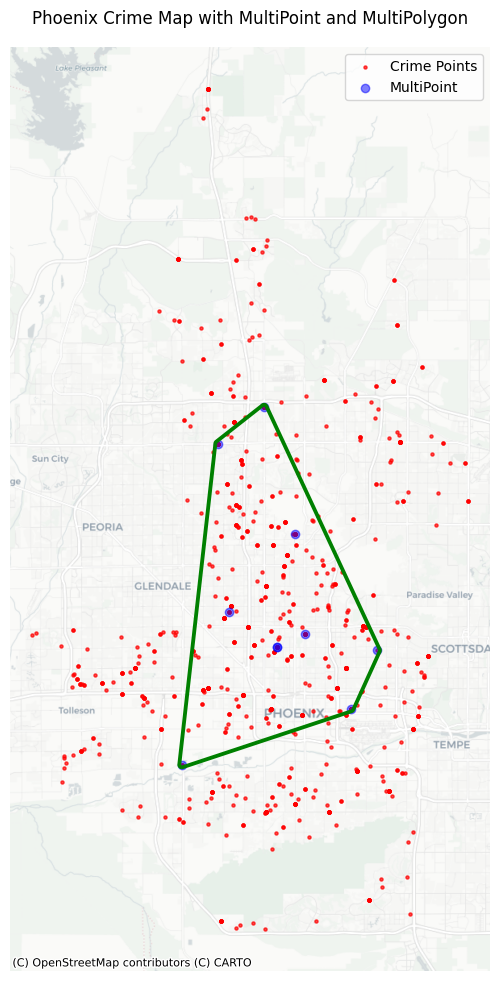

In [7]:
##project to Web Mercator
gdf_web = gdf.to_crs(epsg=3857)

##MultiPoint
sample_points = gdf_web.geometry.head(10)
multi_point = MultiPoint(sample_points)

##MultiPolygon from buffered areas
poly1 = sample_points.buffer(200).union_all().convex_hull
poly2 = sample_points.buffer(300).union_all().convex_hull
multi_poly = MultiPolygon([poly1, poly2])

##plot
fig, ax = plt.subplots(figsize=(12, 12))
gdf_web.plot(ax=ax, markersize=5, alpha=0.7, color='red', label='Crime Points')
gpd.GeoSeries([multi_point], crs=3857).plot(ax=ax, color='blue', alpha=0.5, label='MultiPoint')
gpd.GeoSeries([multi_poly], crs=3857).plot(ax=ax, edgecolor='green', facecolor='none', linewidth=2, label='MultiPolygon')

##basemap
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)

##title/legend
ax.set_title("Phoenix Crime Map with MultiPoint and MultiPolygon")
ax.legend()
ax.axis("off")
plt.show()


In [8]:
##stay within projected GeoDataFrame
gdf_proj = gdf.to_crs(epsg=3857).copy()

##get x, y coordinates from geometry for clustering
coords = np.array([(geom.x, geom.y) for geom in gdf_proj.geometry])

##DBSCAN
db = DBSCAN(eps=300, min_samples=8, algorithm='ball_tree', metric='euclidean')  # eps in meters
gdf_proj["cluster"] = db.fit_predict(coords)

##check number of clusters (label -1 = noise)
num_clusters = len(set(gdf_proj["cluster"])) - (1 if -1 in gdf_proj["cluster"].values else 0)
print(f"DBSCAN completed. Found {num_clusters} clusters.")


✅ DBSCAN completed. Found 28 clusters.


In [9]:
print(gdf_proj["cluster"].value_counts().sort_index())


cluster
-1     604
 0      10
 1      23
 2      10
 3      39
 4       9
 5      13
 6      16
 7       8
 8      13
 9       8
 10     12
 11      9
 12     20
 13     14
 14     13
 15     22
 16      8
 17     12
 18     17
 19     14
 20     15
 21     14
 22     28
 23      8
 24     12
 25     10
 26     10
 27      9
Name: count, dtype: int64


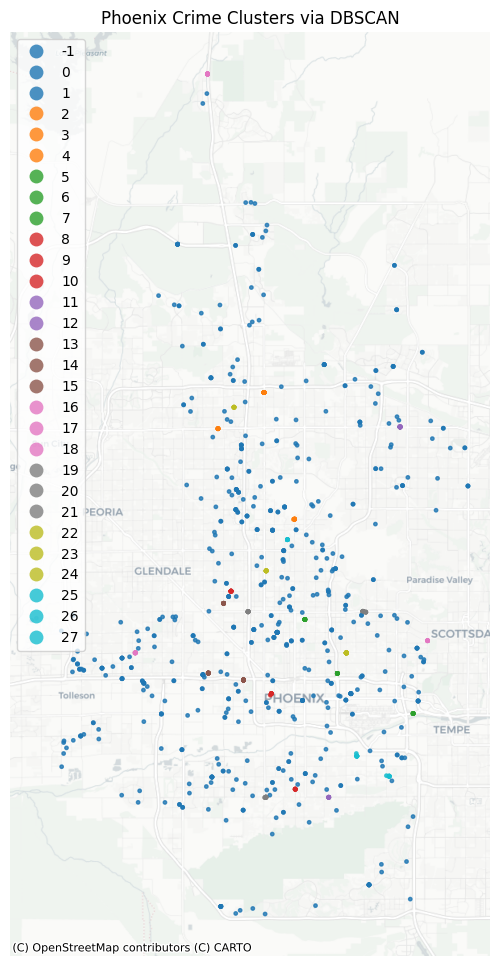

In [10]:
fig, ax = plt.subplots(figsize=(12, 12))

##plot each cluster with different color
gdf_proj.plot(ax=ax, column="cluster", categorical=True, legend=True, markersize=6, cmap="tab10", alpha=0.8)

ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)
ax.set_title("Phoenix Crime Clusters via DBSCAN")
ax.axis("off")
plt.show()


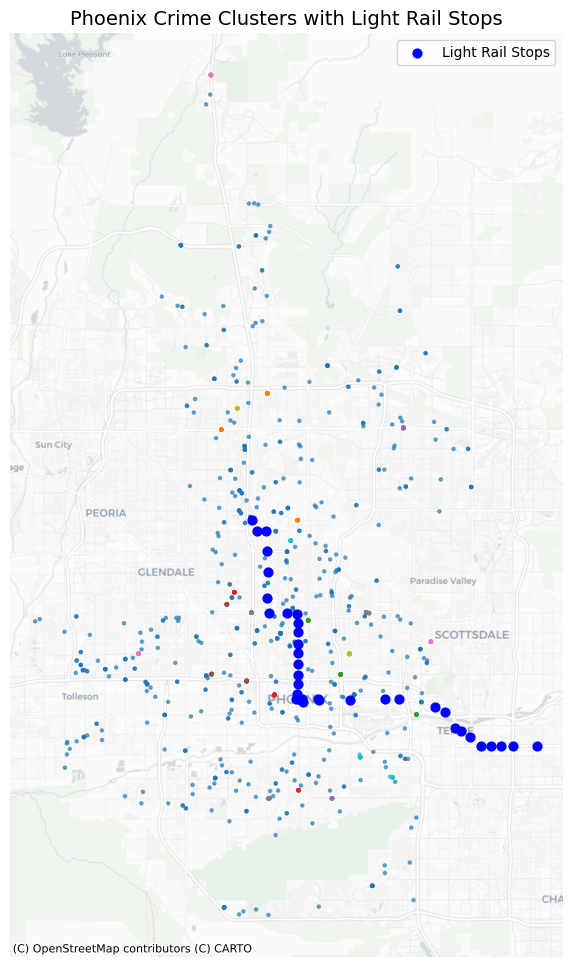

In [11]:
##light rail stops
rail_stops = gpd.read_file(r"C:\Users\Rbrig\OneDrive\Documents\GIS Projects\GIS 322\Final Project\Light_Rail_Stops.geojson")

##match crime GeoDataFrame
rail_stops_web = rail_stops.to_crs(epsg=3857)

##plot both crime clusters and light rail stops
fig, ax = plt.subplots(figsize=(12, 12))

##plot crime clusters
gdf_proj.plot(ax=ax, column="cluster", categorical=True, legend=True, markersize=5, cmap="tab10", alpha=0.6)

##plot light rail stops
rail_stops_web.plot(ax=ax, color="blue", marker="o", markersize=40, label="Light Rail Stops")

##basemap
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)

##style
ax.set_title("Phoenix Crime Clusters with Light Rail Stops", fontsize=14)
ax.legend()
ax.axis("off")
plt.show()


In [12]:


##GeoDataFrames are in the same CRS
crimes = gdf_proj.copy()  ##crime data projected to EPSG:3857
stops = rail_stops.to_crs(crimes.crs)

##unary union of all rail stop geometries (for fast nearest neighbor search)
stops_union = stops.unary_union

##function to calculate nearest distance
def nearest_stop_distance(crime_point):
    nearest_geom = nearest_points(crime_point, stops_union)[1]
    return crime_point.distance(nearest_geom)

##apply to each crime point
crimes["nearest_rail_dist_m"] = crimes.geometry.apply(nearest_stop_distance)

##inspect
print(crimes[["cluster", "nearest_rail_dist_m"]].head())


   cluster  nearest_rail_dist_m
0        0           638.677766
1       -1         11607.938626
2        1          1649.374735
3        2          3170.809121
4        1          1649.374735


C:\Users\Rbrig\AppData\Local\Temp\ipykernel_7224\920217906.py:8: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  stops_union = stops.unary_union


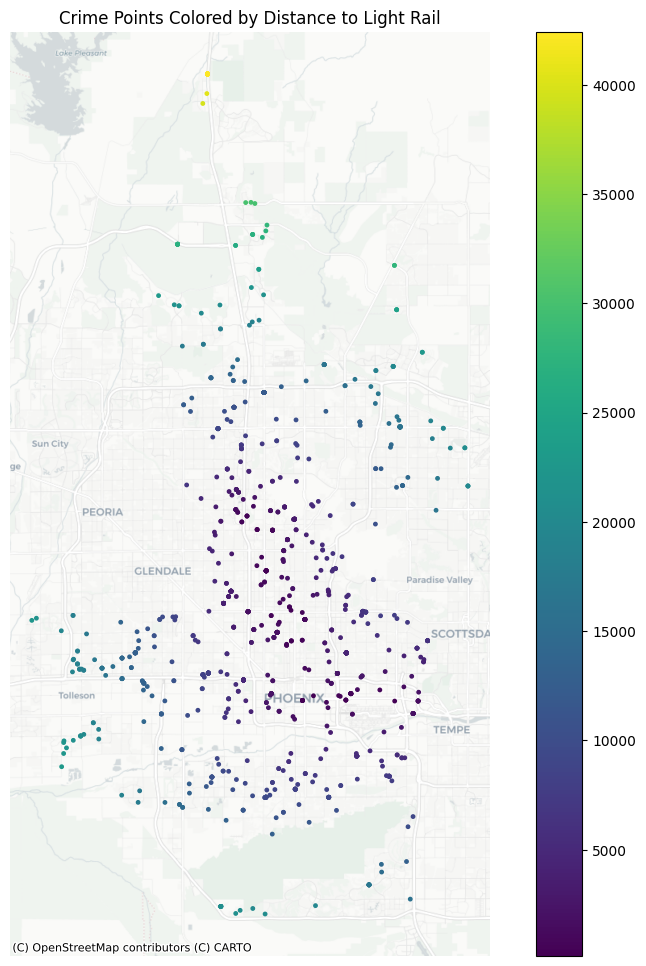

In [13]:
fig, ax = plt.subplots(figsize=(12, 12))
crimes.plot(ax=ax, column="nearest_rail_dist_m", cmap="viridis", legend=True, markersize=6)
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)
ax.set_title("Crime Points Colored by Distance to Light Rail")
ax.axis("off")
plt.show()


In [14]:
from shapely.ops import unary_union

##reproject both to Web Mercator
gdf_proj = gdf.to_crs(epsg=3857)
stops_proj = stops.to_crs(epsg=3857)

##unified geometry of all light rail stops
stops_union = stops_proj.unary_union

##compute distances in meters
gdf_proj["nearest_rail_dist_m"] = gdf_proj.geometry.distance(stops_union)


C:\Users\Rbrig\AppData\Local\Temp\ipykernel_7224\2170854674.py:8: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  stops_union = stops_proj.unary_union  # Not deprecated in this context


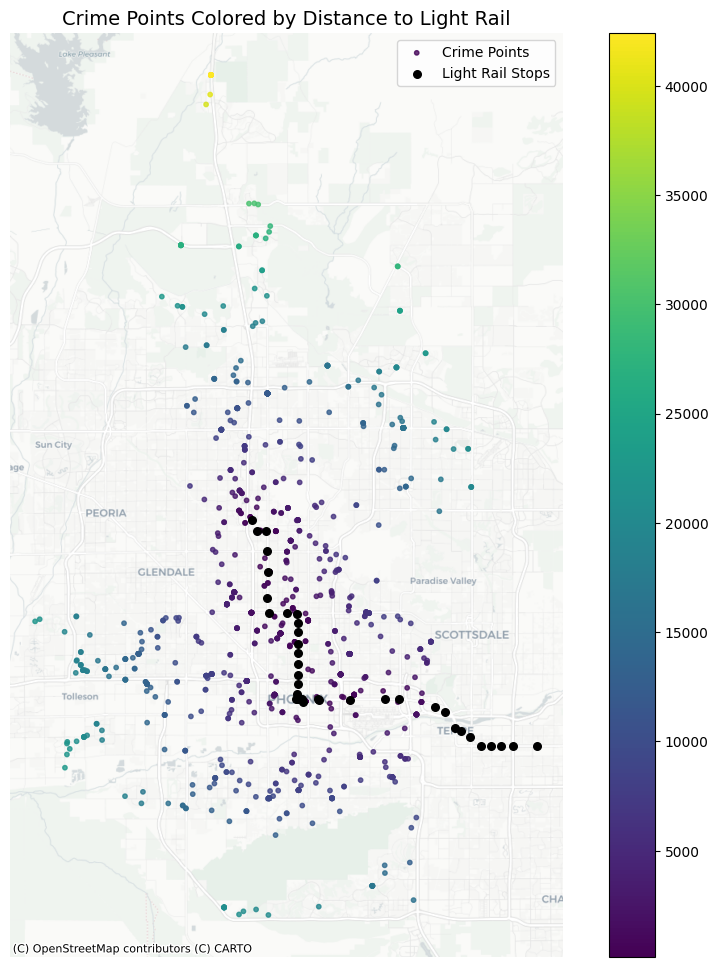

In [15]:
fig, ax = plt.subplots(figsize=(12, 12))

##plot crime points colored by distance
gdf_proj.plot(ax=ax, column="nearest_rail_dist_m", cmap="viridis", legend=True,
              markersize=10, alpha=0.8, label="Crime Points")

##plot light rail stops
stops_proj.plot(ax=ax, color='black', markersize=30, label='Light Rail Stops', zorder=3)

ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)
ax.set_title("Crime Points Colored by Distance to Light Rail", fontsize=14)
ax.axis("off")
ax.legend()
plt.show()


In [17]:


##get coordinates/scale them
coords = gdf_proj[["geometry"]].apply(lambda row: (row.geometry.x, row.geometry.y), axis=1, result_type="expand")
coords.columns = ["x", "y"]
scaled_coords = StandardScaler().fit_transform(coords)

##DBSCAN
db = DBSCAN(eps=0.3, min_samples=10).fit(scaled_coords)

##cluster labels
gdf_proj["cluster"] = db.labels_


In [21]:
##group by DBSCAN cluster and calculate distance statistics
cluster_summary = gdf_proj.groupby("cluster")["nearest_rail_dist_m"].agg(
    count="count",
    mean_distance="mean",
    median_distance="median",
    min_distance="min",
    max_distance="max"
).reset_index()

##round distance columns to 2 decimal places
distance_cols = ["mean_distance", "median_distance", "min_distance", "max_distance"]
cluster_summary[distance_cols] = cluster_summary[distance_cols].round(2)

##sort by avg distance
cluster_summary = cluster_summary.sort_values(by="mean_distance")

##display
import pandas as pd
print(cluster_summary)


   cluster  count  mean_distance  median_distance  min_distance  max_distance
1        0    827        6226.79          5004.98        136.69      20066.27
2        1     56       15886.14         16266.00      12171.45      19825.25
0       -1     58       19343.82         19562.89       6710.10      27787.66
3        2     15       20683.46         20451.22      18664.44      22877.93
4        3     10       20820.68         20895.15      20200.77      21070.29
5        4     15       26413.46         27030.62      21350.27      30070.51
6        5     19       42176.46         42417.31      39681.99      42417.31


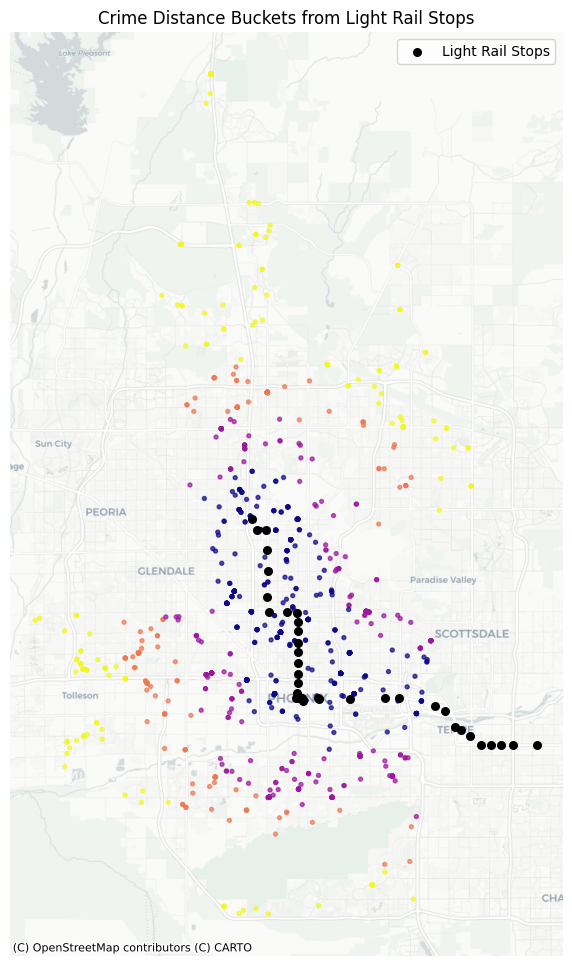

In [22]:
##distance bucket column
gdf_proj["distance_bucket_km"] = pd.cut(gdf_proj["nearest_rail_dist_m"] / 1000,
    bins=[0, 5, 10, 15, float("inf")],
    labels=["<5 km", "5–10 km", "10–15 km", "15+ km"]
)

##plot
fig, ax = plt.subplots(figsize=(12, 12))
gdf_proj.plot(ax=ax, column="distance_bucket_km", cmap="plasma", legend=True, markersize=8, alpha=0.7)
stops_proj.plot(ax=ax, color='black', markersize=30, label='Light Rail Stops')
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)
ax.set_title("Crime Distance Buckets from Light Rail Stops")
ax.legend()
ax.axis("off")
plt.show()


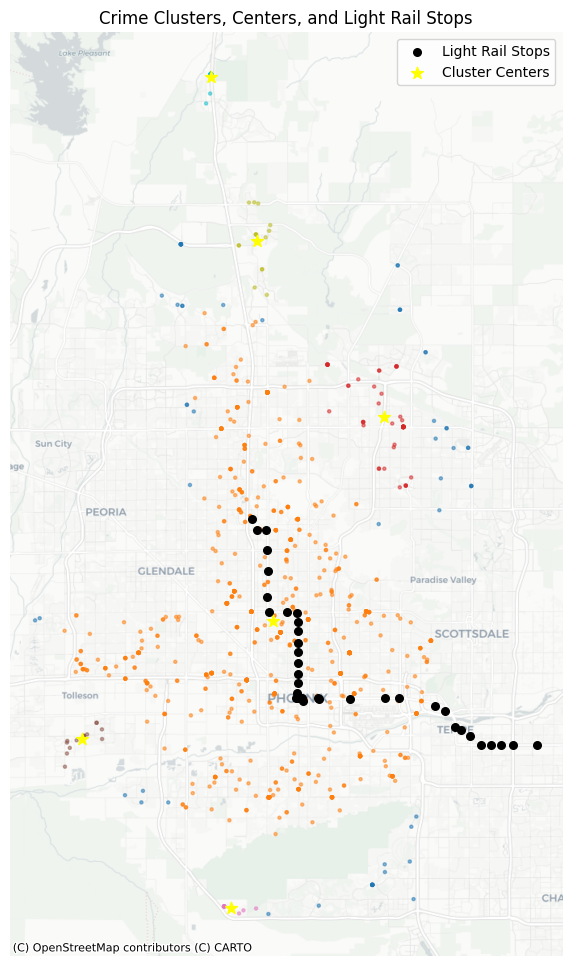

In [23]:
from shapely.geometry import MultiPoint

##get cluster centers
centers = gdf_proj[gdf_proj["cluster"] != -1].groupby("cluster")["geometry"].apply(lambda pts: MultiPoint(pts.tolist()).centroid)
centers_gdf = gpd.GeoDataFrame(centers, geometry=centers, crs=gdf_proj.crs).reset_index()

##plot
fig, ax = plt.subplots(figsize=(12, 12))
gdf_proj.plot(ax=ax, column="cluster", cmap="tab10", alpha=0.5, markersize=5)
stops_proj.plot(ax=ax, color="black", markersize=30, label="Light Rail Stops")
centers_gdf.plot(ax=ax, color="yellow", markersize=80, marker="*", label="Cluster Centers")
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)
ax.set_title("Crime Clusters, Centers, and Light Rail Stops")
ax.legend()
ax.axis("off")
plt.show()


In [24]:
##Downtown Phoenix
downtown_point = Point(-112.0740, 33.4484)
downtown_proj = gpd.GeoSeries([downtown_point], crs=4326).to_crs(gdf_proj.crs).iloc[0]

##distance from crime to downtown
gdf_proj["dist_to_downtown_m"] = gdf_proj.geometry.distance(downtown_proj)


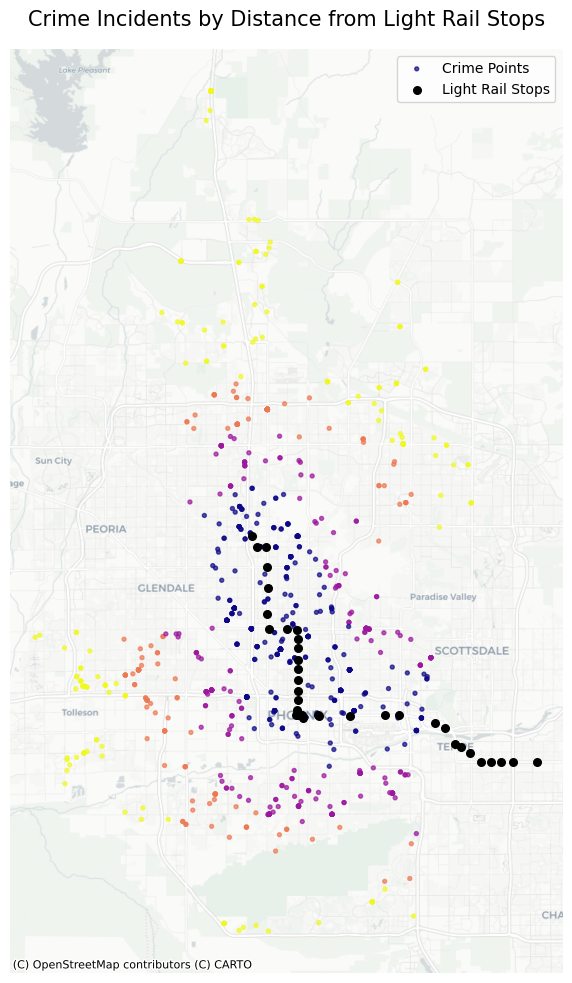

In [25]:
##distance buckets (km)
gdf_proj["distance_bucket_km"] = pd.cut(
    gdf_proj["nearest_rail_dist_m"] / 1000,  # convert to km
    bins=[0, 5, 10, 15, float("inf")],
    labels=["<5 km", "5–10 km", "10–15 km", "15+ km"]
)

##plot categorized map
fig, ax = plt.subplots(figsize=(12, 12))
gdf_proj.plot(
    ax=ax,
    column="distance_bucket_km",
    cmap="plasma",
    legend=True,
    markersize=8,
    alpha=0.7,
    label="Crime Points"
)

##add light rail stops
stops_proj.plot(ax=ax, color='black', markersize=30, label='Light Rail Stops', zorder=3)

##basemap and styling
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)
ax.set_title("Crime Incidents by Distance from Light Rail Stops", fontsize=15)
ax.legend()
ax.axis("off")
plt.show()


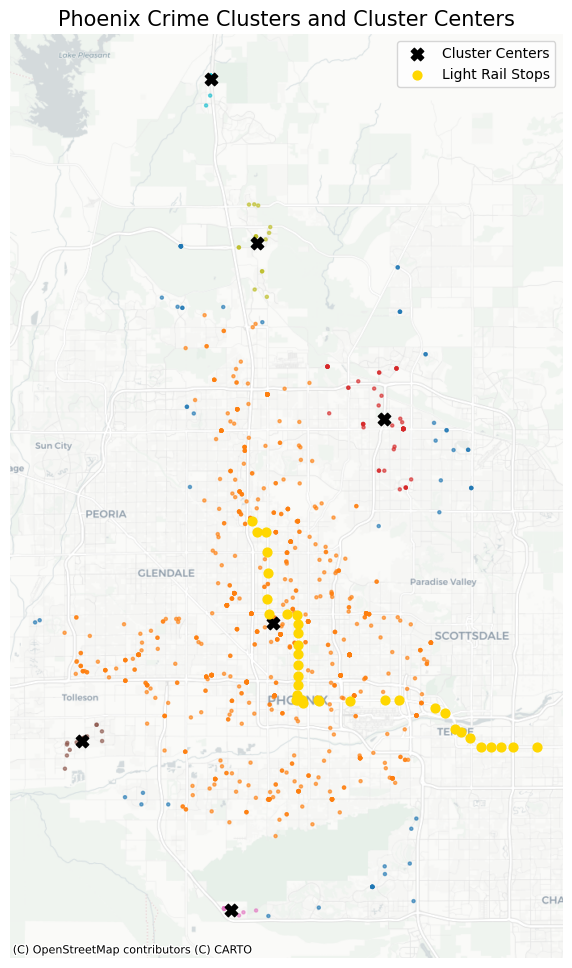

In [27]:


##drop noise
clustered = gdf_proj[gdf_proj["cluster"] != -1].copy()

##compute centroids of each cluster
cluster_centers = (
    clustered.groupby("cluster")["geometry"]
    .apply(lambda pts: MultiPoint(pts.tolist()).centroid)
    .reset_index()
    .rename(columns={ "geometry": "center_geometry" })  # name it explicitly
)

##convert to GeoDataFrame
cluster_centers_gdf = gpd.GeoDataFrame(cluster_centers, geometry="center_geometry", crs=gdf_proj.crs)

##plot
fig, ax = plt.subplots(figsize=(12, 12))

##plot
gdf_proj.plot(ax=ax, column="cluster", categorical=True, legend=True,
              markersize=5, cmap="tab10", alpha=0.6)

##cluster centers
cluster_centers_gdf.plot(ax=ax, color='black', marker='X', markersize=80, label="Cluster Centers")

##rail stops
stops_proj.plot(ax=ax, color='gold', markersize=40, label='Light Rail Stops')

##basemap
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)

##final touches
ax.set_title("Phoenix Crime Clusters and Cluster Centers", fontsize=15)
ax.axis("off")
ax.legend()
plt.show()


In [28]:


##ZIP file
zip_path = r"C:\Users\Rbrig\OneDrive\Documents\GIS Projects\GIS 322\Final Project\tl_2019_04_prisecroads.zip"

##unzip 
extract_dir = zip_path.replace('.zip', '')
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

##shp file
for file in os.listdir(extract_dir):
    if file.endswith(".shp"):
        shapefile_path = os.path.join(extract_dir, file)
        break

##highway shapefile
highways_gdf = gpd.read_file(shapefile_path)

##CRS and preview
print(highways_gdf.crs)
print(highways_gdf.head())


EPSG:4269
        LINEARID        FULLNAME RTTYP  MTFCC  \
0  1104485763809   E Business Lp     M  S1200   
1  1103716989290   E Business Lp     M  S1200   
2  1104428336208    I- 40 Bus Lp     I  S1200   
3  1104428336989    I- 40 Bus Lp     I  S1200   
4  1106087846143  US Hwy 180 Alt     U  S1200   

                                            geometry  
0  LINESTRING (-109.44968 32.31723, -109.44988 32...  
1  LINESTRING (-109.48705 32.32623, -109.48587 32...  
2  LINESTRING (-112.85587 35.31021, -112.85578 35...  
3  LINESTRING (-112.49696 35.22017, -112.49687 35...  
4  LINESTRING (-109.60333 34.47508, -109.60333 34...  


In [29]:
highways_proj = highways_gdf.to_crs(epsg=3857)


In [32]:
#3crime points to create a bounding box with slight buffer
bbox = gdf_proj.total_bounds  # [minx, miny, maxx, maxy]
buffer = 5000  # meters
minx, miny, maxx, maxy = bbox
phoenix_bounds = gpd.GeoDataFrame(geometry=[box(minx - buffer, miny - buffer, maxx + buffer, maxy + buffer)],
                                   crs=gdf_proj.crs)

##spatial clip
highways_clip = gpd.overlay(highways_proj, phoenix_bounds, how='intersection')


In [34]:


##uinion highway lines
highway_union = highways_clip.union_all()

##compute distance to nearest highway in meters
gdf_proj["nearest_highway_dist_m"] = gdf_proj.geometry.apply(lambda pt: pt.distance(highway_union))


In [36]:
##same CRS
gdf_proj = gdf_proj.to_crs(highways_clip.crs)

##unified highway geometry
highway_union = highways_clip.union_all()

##compute/round distances to 2 decimal places
gdf_proj["nearest_highway_dist_m"] = gdf_proj.geometry.apply(
    lambda pt: round(pt.distance(highway_union), 2)
)

# 4. Preview
gdf_proj[["cluster", "nearest_highway_dist_m"]].head()


cluster  nearest_highway_dist_m
0        0                 1205.24
1        0                 6819.66
2        0                 2707.17
3        0                 4388.61
4        0                 2707.17

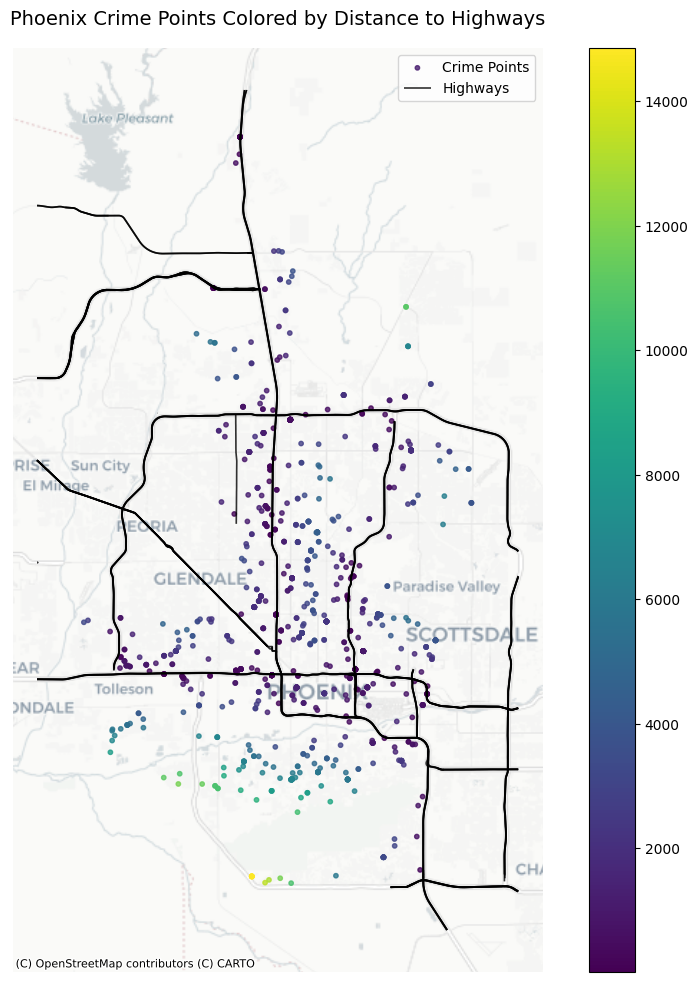

In [39]:
##setup plot
fig, ax = plt.subplots(figsize=(12, 12))

##plot crime points with gradient color
gdf_proj.plot(
    ax=ax,
    column="nearest_highway_dist_m",
    cmap="viridis",
    legend=True,
    markersize=10,
    alpha=0.8,
    label="Crime Points"
)

##plot highway lines (clipped to Phoenix)
highways_clip.plot(
    ax=ax,
    color="black",
    linewidth=1.2,
    alpha=0.8,
    label="Highways"
)

##bbasemap
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)

##style
ax.set_title("Phoenix Crime Points Colored by Distance to Highways", fontsize=14)
ax.axis("off")
ax.legend()
plt.show()


## Maps ##

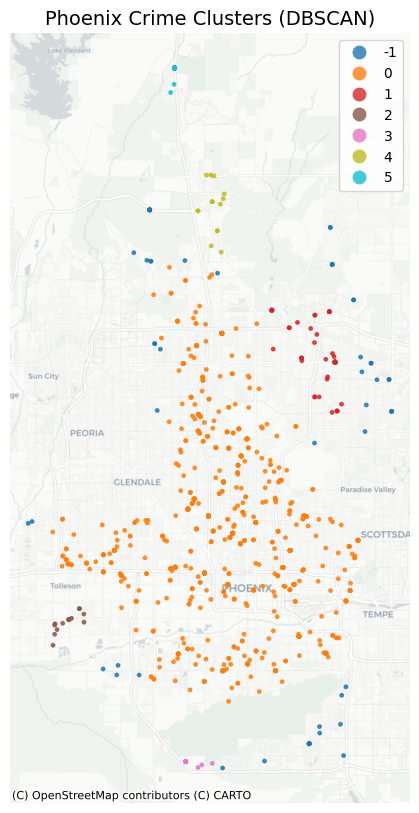

In [40]:
##DBSCAN Crime Clusters (Base Map)
fig, ax = plt.subplots(figsize=(10, 10))
gdf_proj.plot(ax=ax, column="cluster", categorical=True, cmap="tab10", markersize=6, alpha=0.8, legend=True)
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)
ax.set_title("Phoenix Crime Clusters (DBSCAN)", fontsize=14)
ax.axis("off")
plt.show()


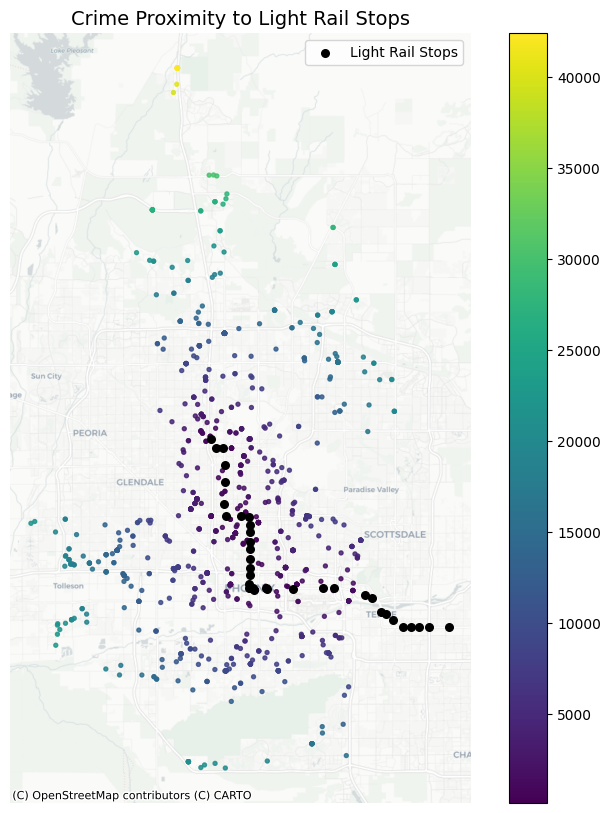

In [41]:
##Crime Distance to Light Rail
fig, ax = plt.subplots(figsize=(10, 10))
gdf_proj.plot(ax=ax, column="nearest_rail_dist_m", cmap="viridis", markersize=8, alpha=0.85, legend=True)
stops_proj.plot(ax=ax, color="black", markersize=30, label="Light Rail Stops")
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)
ax.set_title("Crime Proximity to Light Rail Stops", fontsize=14)
ax.axis("off")
plt.legend()
plt.show()


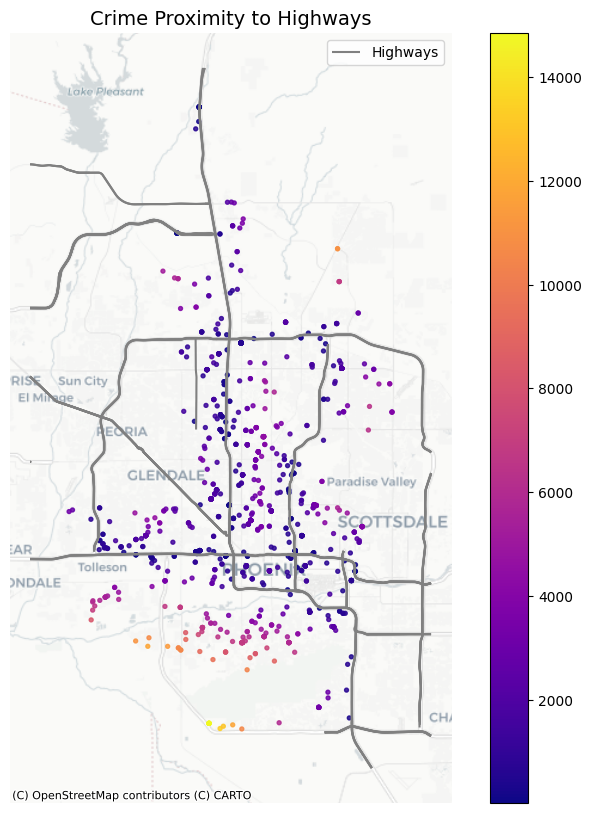

In [42]:
##Crime Distance to Highways
fig, ax = plt.subplots(figsize=(10, 10))
gdf_proj.plot(ax=ax, column="nearest_highway_dist_m", cmap="plasma", markersize=8, alpha=0.85, legend=True)
highways_clip.plot(ax=ax, color="gray", linewidth=1.5, label="Highways", zorder=3)
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)
ax.set_title("Crime Proximity to Highways", fontsize=14)
ax.axis("off")
plt.legend()
plt.show()


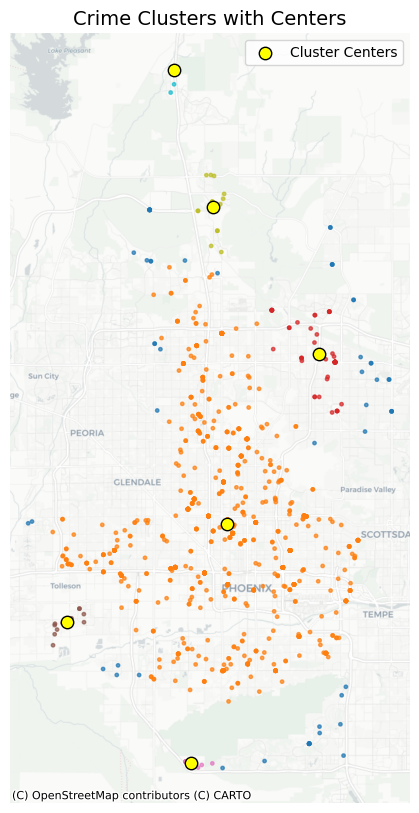

In [43]:
##Crime Cluster Centers
fig, ax = plt.subplots(figsize=(10, 10))
gdf_proj.plot(ax=ax, column="cluster", categorical=True, cmap="tab10", markersize=6, alpha=0.7, legend=True)
cluster_centers_gdf.plot(ax=ax, color="yellow", edgecolor="black", markersize=80, label="Cluster Centers")
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)
ax.set_title("Crime Clusters with Centers", fontsize=14)
ax.axis("off")
plt.legend()
plt.show()
